In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on FashionMNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on FashionMNIST dataset

In [2]:
#from torchvision.datasets import FashionMNIST
from torchvision import transforms

import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset


mean, std = 0.28604059698879553, 0.35302424451492237

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]

train_dataset = loadDataset('FashionMNIST', classes, instances, mode='train')
test_dataset = loadDataset('FashionMNIST', classes, instances, mode='test')

'''
train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
                            '''
n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(fashion_mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [25]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet(1)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/50000 (0%)]	Loss: 2.361142	Accuracy: 14.0625
Train: [12800/50000 (26%)]	Loss: 2.288847	Accuracy: 21.2086397059
Train: [25600/50000 (51%)]	Loss: 1.237354	Accuracy: 36.5717821782
Train: [38400/50000 (77%)]	Loss: 0.948447	Accuracy: 46.1273799669
Epoch: 1/20. Train set: Average loss: 1.3269	Accuracy: 52.48
Epoch: 1/20. Validation set: Average loss: 0.7612	Accuracy: 73.13
Train: [0/50000 (0%)]	Loss: 0.661398	Accuracy: 75.78125
Train: [12800/50000 (26%)]	Loss: 0.653238	Accuracy: 77.3897058824
Train: [25600/50000 (51%)]	Loss: 0.594860	Accuracy: 78.8637066832
Train: [38400/50000 (77%)]	Loss: 0.554597	Accuracy: 79.770281457
Epoch: 2/20. Train set: Average loss: 0.5855	Accuracy: 80.736
Epoch: 2/20. Validation set: Average loss: 0.5538	Accuracy: 83.07
Train: [0/50000 (0%)]	Loss: 0.473243	Accuracy: 82.421875
Train: [12800/50000 (26%)]	Loss: 0.474656	Accuracy: 84.9264705882
Train: [25600/50000 (51%)]	Loss: 0.440426	Accuracy: 85.2181311881
Train: [38400/50000 (77%)]	Loss: 0.448300	Accuracy

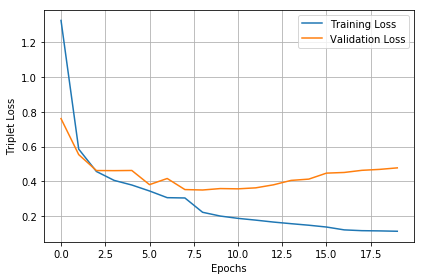

In [26]:
lossDict = fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])
showLossHist(lossDict)

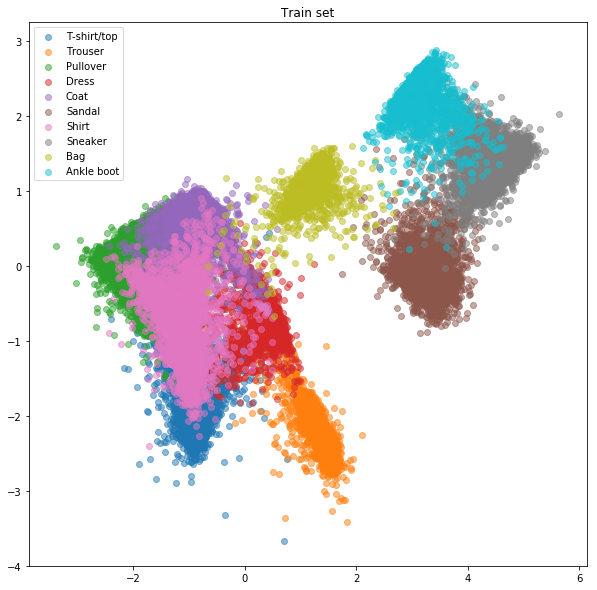

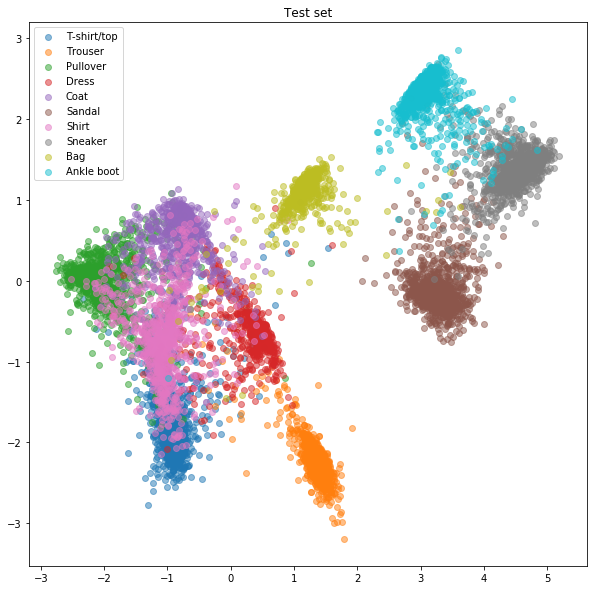

In [34]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [28]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet(1)
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.242762
Train: [12800/50000 (26%)]	Loss: 0.061106
Train: [25600/50000 (51%)]	Loss: 0.049142
Train: [38400/50000 (77%)]	Loss: 0.045622
Epoch: 1/20. Train set: Average loss: 0.0504
Epoch: 1/20. Validation set: Average loss: 0.0440
Train: [0/50000 (0%)]	Loss: 0.033987
Train: [12800/50000 (26%)]	Loss: 0.041447
Train: [25600/50000 (51%)]	Loss: 0.038726
Train: [38400/50000 (77%)]	Loss: 0.037117
Epoch: 2/20. Train set: Average loss: 0.0388
Epoch: 2/20. Validation set: Average loss: 0.0403
Train: [0/50000 (0%)]	Loss: 0.039984
Train: [12800/50000 (26%)]	Loss: 0.034987
Train: [25600/50000 (51%)]	Loss: 0.033981
Train: [38400/50000 (77%)]	Loss: 0.033112
Epoch: 3/20. Train set: Average loss: 0.0338
Epoch: 3/20. Validation set: Average loss: 0.0343
Train: [0/50000 (0%)]	Loss: 0.040402
Train: [12800/50000 (26%)]	Loss: 0.030279
Train: [25600/50000 (51%)]	Loss: 0.031428
Train: [38400/50000 (77%)]	Loss: 0.030282
Epoch: 4/20. Train set: Average loss: 0.0303
Epoch: 4/20. Valid

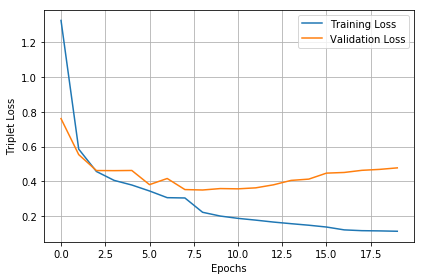

In [29]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

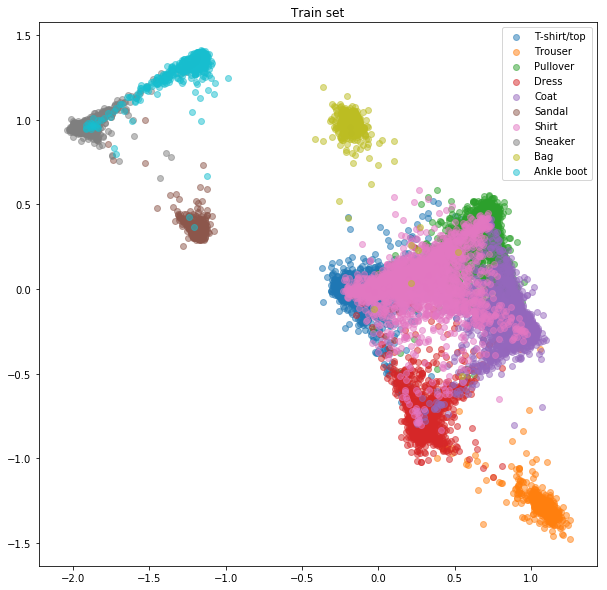

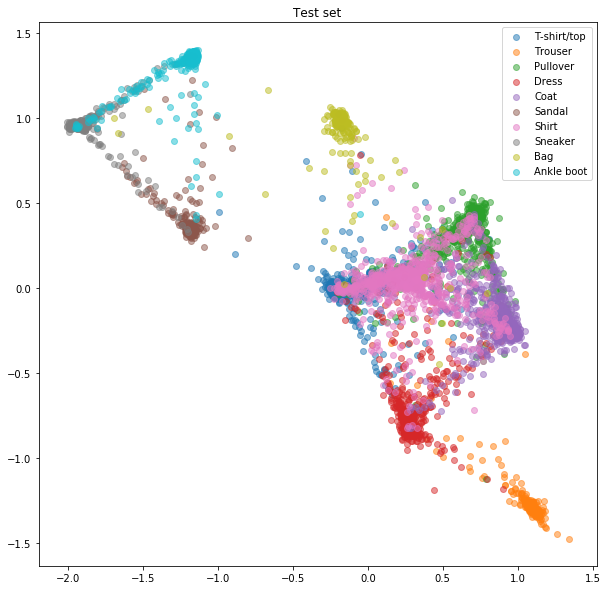

In [30]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$)

In [31]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet(1)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.999960
Train: [12800/50000 (26%)]	Loss: 0.274370
Train: [25600/50000 (51%)]	Loss: 0.199715
Train: [38400/50000 (77%)]	Loss: 0.168550
Epoch: 1/20. Train set: Average loss: 0.2055
Epoch: 1/20. Validation set: Average loss: 0.1627
Train: [0/50000 (0%)]	Loss: 0.171795
Train: [12800/50000 (26%)]	Loss: 0.158182
Train: [25600/50000 (51%)]	Loss: 0.141515
Train: [38400/50000 (77%)]	Loss: 0.143258
Epoch: 2/20. Train set: Average loss: 0.1416
Epoch: 2/20. Validation set: Average loss: 0.1452
Train: [0/50000 (0%)]	Loss: 0.191826
Train: [12800/50000 (26%)]	Loss: 0.135875
Train: [25600/50000 (51%)]	Loss: 0.125887
Train: [38400/50000 (77%)]	Loss: 0.118204
Epoch: 3/20. Train set: Average loss: 0.1249
Epoch: 3/20. Validation set: Average loss: 0.1255
Train: [0/50000 (0%)]	Loss: 0.074449
Train: [12800/50000 (26%)]	Loss: 0.118799
Train: [25600/50000 (51%)]	Loss: 0.110120
Train: [38400/50000 (77%)]	Loss: 0.110351
Epoch: 4/20. Train set: Average loss: 0.1115
Epoch: 4/20. Valid

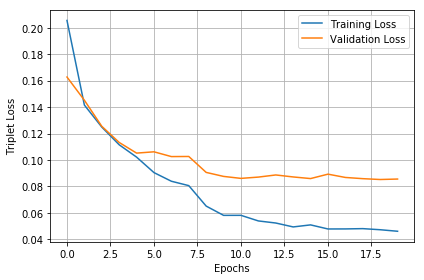

In [32]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

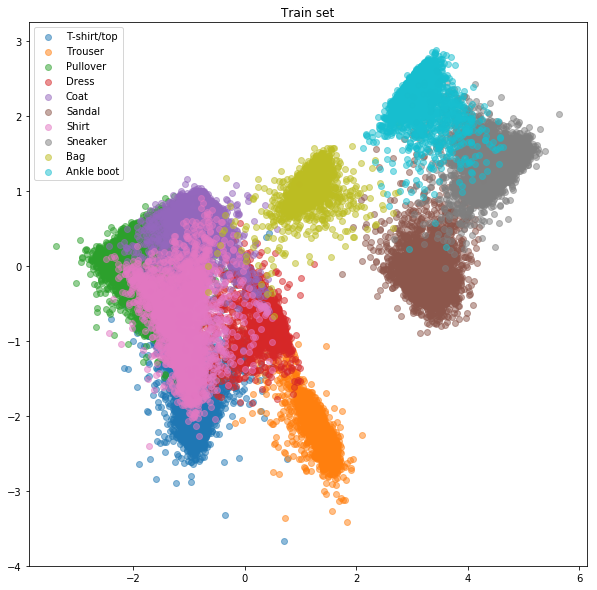

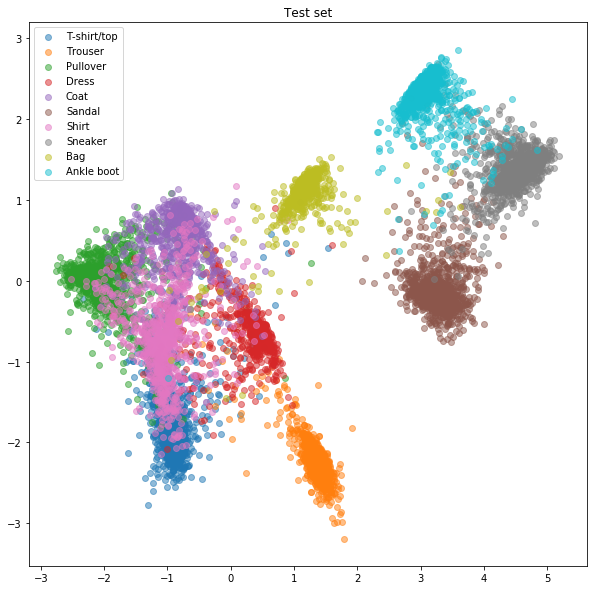

In [33]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

### All Positive Pairs 

In [6]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=False))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/50000 (0%)]	Loss: 0.007461
Train: [12500/50000 (25%)]	Loss: 0.010616
Train: [25000/50000 (50%)]	Loss: 0.010044
Train: [37500/50000 (75%)]	Loss: 0.010179
Epoch: 1/20. Train set: Average loss: 0.0101
Epoch: 1/20. Validation set: Average loss: 0.0258
Train: [0/50000 (0%)]	Loss: 0.009707
Train: [12500/50000 (25%)]	Loss: 0.010117
Train: [25000/50000 (50%)]	Loss: 0.010301
Train: [37500/50000 (75%)]	Loss: 0.010135
Epoch: 2/20. Train set: Average loss: 0.0103
Epoch: 2/20. Validation set: Average loss: 0.0257
Train: [0/50000 (0%)]	Loss: 0.010856
Train: [12500/50000 (25%)]	Loss: 0.009819
Train: [25000/50000 (50%)]	Loss: 0.010067
Train: [37500/50000 (75%)]	Loss: 0.010400
Epoch: 3/20. Train set: Average loss: 0.0099
Epoch: 3/20. Validation set: Average loss: 0.0262
Train: [0/50000 (0%)]	Loss: 0.009883
Train: [12500/50000 (25%)]	Loss: 0.010394
Train: [25000/50000 (50%)]	Loss: 0.010023
Train: [37500/50000 (75%)]	Loss: 0.010144
Epoch: 4/20. Train set: Average loss: 0.0101
Epoch: 4/20. Valid

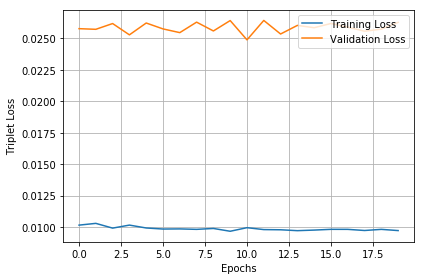

In [37]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

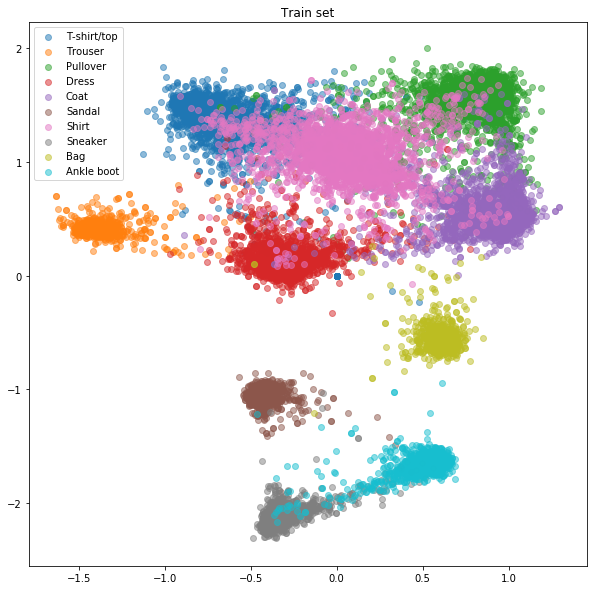

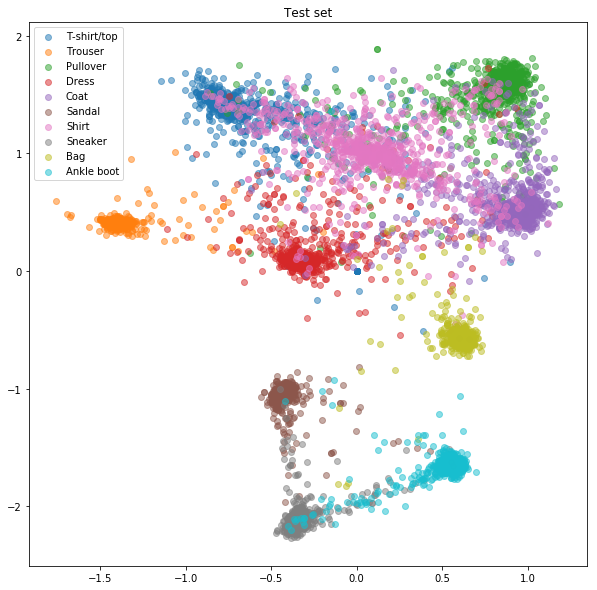

In [38]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

### Hard Negative Pairs

In [7]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/50000 (0%)]	Loss: 0.495052
Train: [12500/50000 (25%)]	Loss: 0.339986
Train: [25000/50000 (50%)]	Loss: 0.267242
Train: [37500/50000 (75%)]	Loss: 0.234035
Epoch: 1/20. Train set: Average loss: 0.2669
Epoch: 1/20. Validation set: Average loss: 0.2110
Train: [0/50000 (0%)]	Loss: 0.199698
Train: [12500/50000 (25%)]	Loss: 0.198445
Train: [25000/50000 (50%)]	Loss: 0.189868
Train: [37500/50000 (75%)]	Loss: 0.180791
Epoch: 2/20. Train set: Average loss: 0.1869
Epoch: 2/20. Validation set: Average loss: 0.1839
Train: [0/50000 (0%)]	Loss: 0.178719
Train: [12500/50000 (25%)]	Loss: 0.163270
Train: [25000/50000 (50%)]	Loss: 0.154913
Train: [37500/50000 (75%)]	Loss: 0.158724
Epoch: 3/20. Train set: Average loss: 0.1582
Epoch: 3/20. Validation set: Average loss: 0.1623
Train: [0/50000 (0%)]	Loss: 0.157344
Train: [12500/50000 (25%)]	Loss: 0.136914
Train: [25000/50000 (50%)]	Loss: 0.138436
Train: [37500/50000 (75%)]	Loss: 0.134703
Epoch: 4/20. Train set: Average loss: 0.1376
Epoch: 4/20. Valid

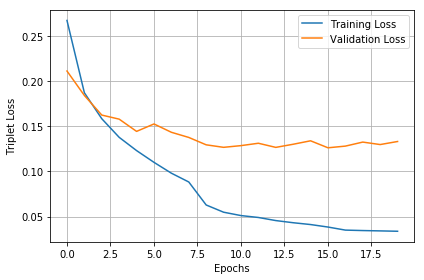

In [8]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

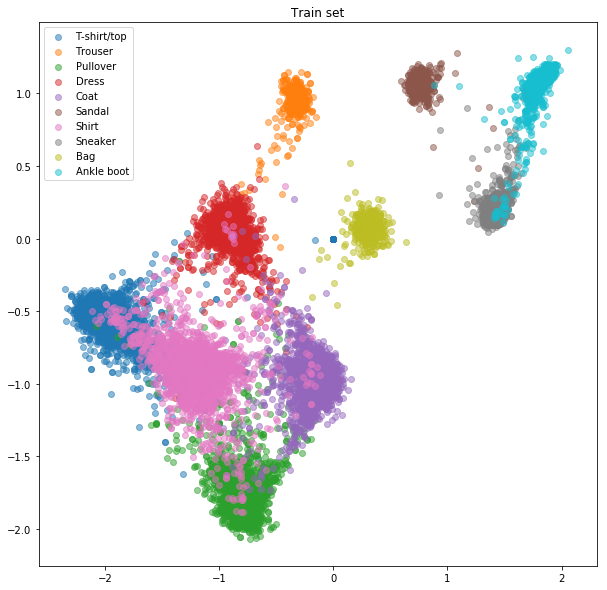

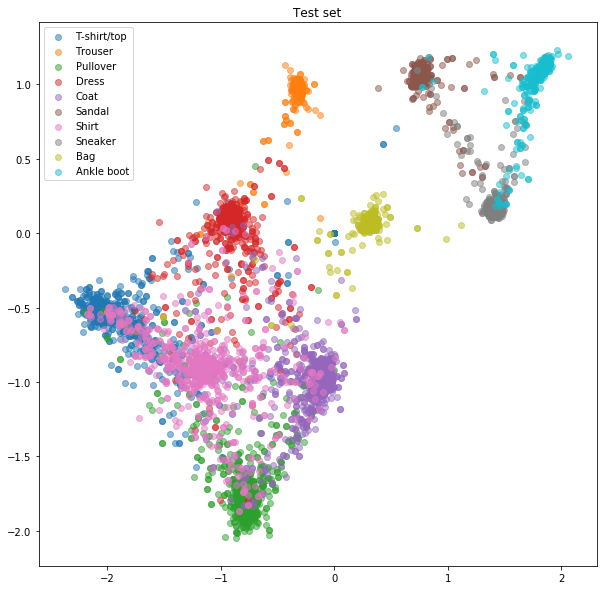

In [9]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

## Online triplet selection

### Random Negative Triplet Selection

In [11]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/50000 (0%)]	Loss: 0.999679	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 0.997081	Average nonzero triplets: 2792.92156863
Train: [25000/50000 (50%)]	Loss: 0.994617	Average nonzero triplets: 2633.25742574
Train: [37500/50000 (75%)]	Loss: 0.990474	Average nonzero triplets: 2540.65562914
Epoch: 1/20. Train set: Average loss: 0.9955	Average nonzero triplets: 2457.38190955
Epoch: 1/20. Validation set: Average loss: 1.0575	Average nonzero triplets: 2109.79487179
Train: [0/50000 (0%)]	Loss: 1.183501	Average nonzero triplets: 2071.0
Train: [12500/50000 (25%)]	Loss: 0.985134	Average nonzero triplets: 2156.88235294
Train: [25000/50000 (50%)]	Loss: 1.002704	Average nonzero triplets: 2115.36633663
Train: [37500/50000 (75%)]	Loss: 0.989583	Average nonzero triplets: 2099.21854305
Epoch: 2/20. Train set: Average loss: 0.9937	Average nonzero triplets: 2082.89949749
Epoch: 2/20. Validation set: Average loss: 1.0509	Average nonzero triplets: 2113.41025641
Train: [0/50000 (0

Train: [0/50000 (0%)]	Loss: 0.849985	Average nonzero triplets: 836.0
Train: [12500/50000 (25%)]	Loss: 0.795592	Average nonzero triplets: 723.862745098
Train: [25000/50000 (50%)]	Loss: 0.809316	Average nonzero triplets: 706.96039604
Train: [37500/50000 (75%)]	Loss: 0.835876	Average nonzero triplets: 711.668874172
Epoch: 18/20. Train set: Average loss: 0.8055	Average nonzero triplets: 708.045226131
Epoch: 18/20. Validation set: Average loss: 1.3975	Average nonzero triplets: 1768.35897436
Train: [0/50000 (0%)]	Loss: 0.774620	Average nonzero triplets: 605.0
Train: [12500/50000 (25%)]	Loss: 0.762826	Average nonzero triplets: 659.431372549
Train: [25000/50000 (50%)]	Loss: 0.813861	Average nonzero triplets: 664.455445545
Train: [37500/50000 (75%)]	Loss: 0.791017	Average nonzero triplets: 671.814569536
Epoch: 19/20. Train set: Average loss: 0.8008	Average nonzero triplets: 679.778894472
Epoch: 19/20. Validation set: Average loss: 1.3835	Average nonzero triplets: 1766.69230769
Train: [0/50000 (

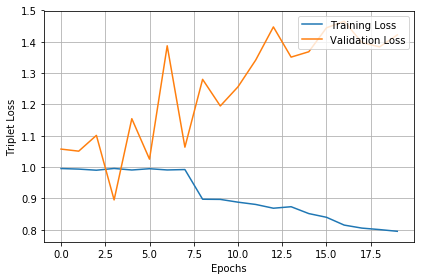

In [12]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

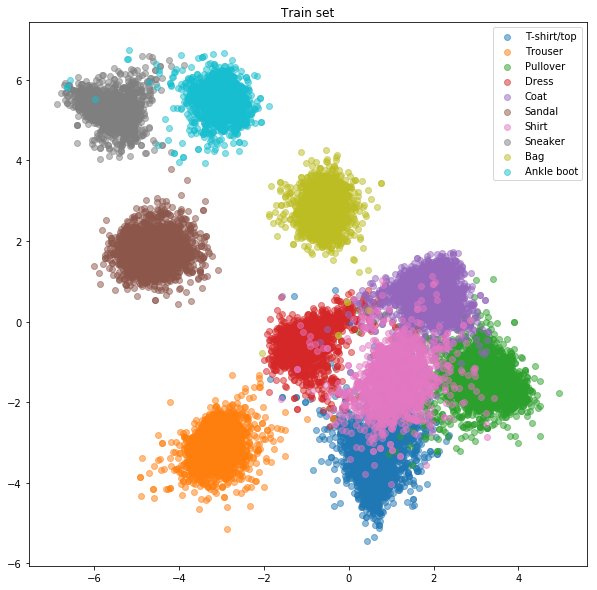

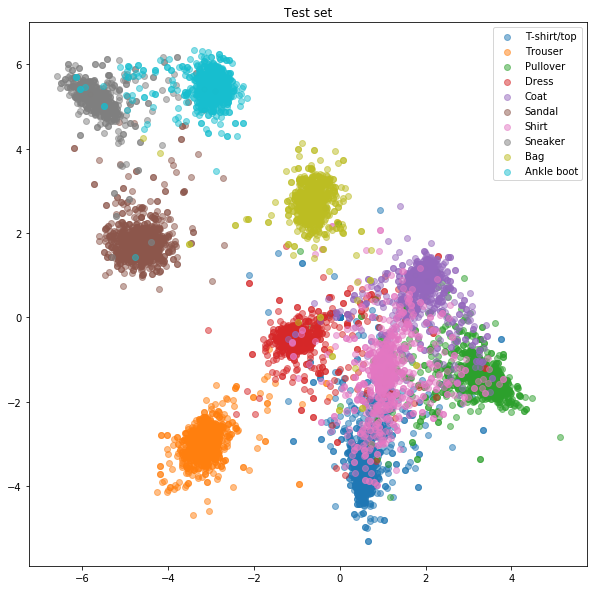

In [14]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

### Hardest Negative Triplet

In [16]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 1.000156	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000483	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000001	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 1/20. Train set: Average loss: 1.0001	Average nonzero triplets: 3000.0
Epoch: 1/20. Validation set: Average loss: 0.9750	Average nonzero triplets: 3000.0
Train: [0/50000 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0


Process Process-88:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "../Datasets/loadDataset.py", line 925, in __getitem__
    img = Image.fromarray(img, mode='L')
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/PIL/Image.py", line 2438, in fromarray
    return frombuffer(mode, size, obj, "raw", rawmode, 0, 1)
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/PIL/Image.py", line 2384, in frombuffer
    im = new(mode, (1, 1))
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/PIL/Image.py", line 2287, in new
    return Image()._new(core.fil

KeyboardInterrupt: 

In [ ]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

### Semi Hard triplets

In [18]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(0.1))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/50000 (0%)]	Loss: 0.999656	Average nonzero triplets: 2996.0
Train: [12500/50000 (25%)]	Loss: 0.950615	Average nonzero triplets: 1326.47058824
Train: [25000/50000 (50%)]	Loss: 0.950124	Average nonzero triplets: 941.227722772
Train: [37500/50000 (75%)]	Loss: 0.949991	Average nonzero triplets: 781.834437086
Epoch: 1/20. Train set: Average loss: 0.9504	Average nonzero triplets: 684.467336683
Epoch: 1/20. Validation set: Average loss: 0.9263	Average nonzero triplets: 379.923076923
Train: [0/50000 (0%)]	Loss: 0.950114	Average nonzero triplets: 329.0
Train: [12500/50000 (25%)]	Loss: 0.950065	Average nonzero triplets: 301.254901961
Train: [25000/50000 (50%)]	Loss: 0.950324	Average nonzero triplets: 275.930693069
Train: [37500/50000 (75%)]	Loss: 0.949855	Average nonzero triplets: 258.503311258
Epoch: 2/20. Train set: Average loss: 0.9500	Average nonzero triplets: 234.507537688
Epoch: 2/20. Validation set: Average loss: 0.9269	Average nonzero triplets: 170.230769231
Train: [0/50000 (0%

Train: [0/50000 (0%)]	Loss: 0.953022	Average nonzero triplets: 2.0
Train: [12500/50000 (25%)]	Loss: 0.929862	Average nonzero triplets: 4.49019607843
Train: [25000/50000 (50%)]	Loss: 0.893119	Average nonzero triplets: 4.73267326733
Train: [37500/50000 (75%)]	Loss: 143.010917	Average nonzero triplets: 4.61589403974
Epoch: 18/20. Train set: Average loss: 36.6248	Average nonzero triplets: 4.59296482412
Epoch: 18/20. Validation set: Average loss: 0.8796	Average nonzero triplets: 4.48717948718
Train: [0/50000 (0%)]	Loss: 0.947617	Average nonzero triplets: 2.0
Train: [12500/50000 (25%)]	Loss: 0.931386	Average nonzero triplets: 4.27450980392
Train: [25000/50000 (50%)]	Loss: 0.931408	Average nonzero triplets: 4.72277227723
Train: [37500/50000 (75%)]	Loss: 0.929508	Average nonzero triplets: 4.80794701987
Epoch: 19/20. Train set: Average loss: 0.9343	Average nonzero triplets: 4.60804020101
Epoch: 19/20. Validation set: Average loss: 0.9247	Average nonzero triplets: 4.51282051282
Train: [0/50000 (

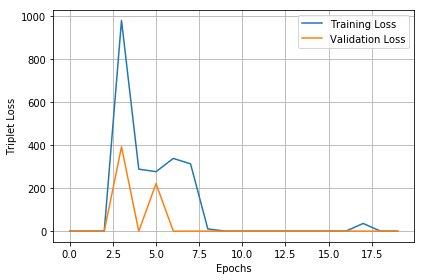

In [19]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

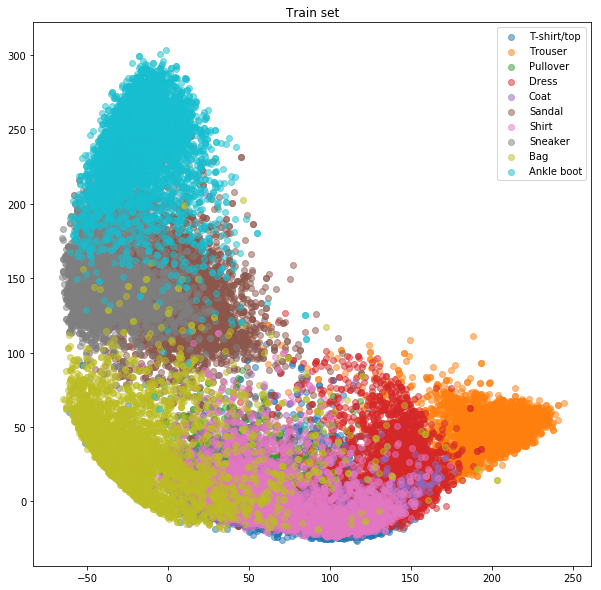

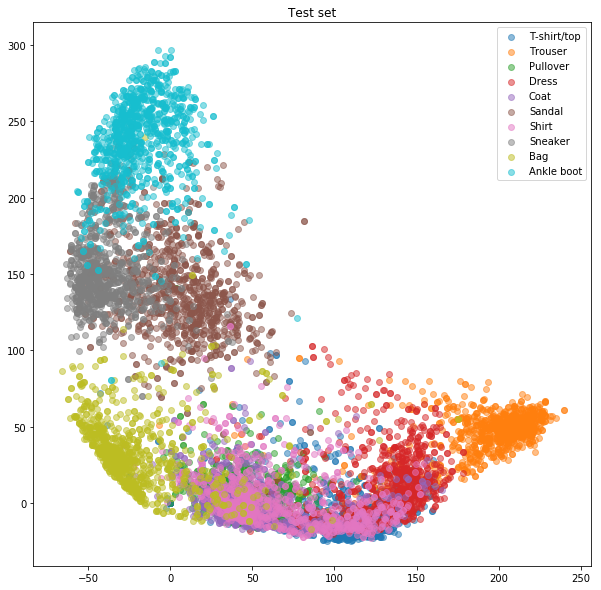

In [20]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

In [ ]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(0.5))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.999504	Average nonzero triplets: 2990.0
Train: [12500/50000 (25%)]	Loss: 0.757319	Average nonzero triplets: 1495.41176471
Train: [25000/50000 (50%)]	Loss: 0.751143	Average nonzero triplets: 1160.03960396
Train: [37500/50000 (75%)]	Loss: 0.748802	Average nonzero triplets: 1001.8410596
Epoch: 1/20. Train set: Average loss: 0.7531	Average nonzero triplets: 904.798994975
Epoch: 1/20. Validation set: Average loss: 0.7323	Average nonzero triplets: 537.435897436
Train: [0/50000 (0%)]	Loss: 0.751700	Average nonzero triplets: 454.0
Train: [12500/50000 (25%)]	Loss: 0.750599	Average nonzero triplets: 539.62745098
Train: [25000/50000 (50%)]	Loss: 0.750762	Average nonzero triplets: 537.198019802
Train: [37500/50000 (75%)]	Loss: 0.751146	Average nonzero triplets: 532.642384106
Epoch: 2/20. Train set: Average loss: 0.7506	Average nonzero triplets: 507.703517588
Epoch: 2/20. Validation set: Average loss: 0.7323	Average nonzero triplets: 379.41025641
Train: [0/50000 (0%)]	

In [ ]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')